In [278]:
import pandas as pd
import numpy as np

In [279]:
df_object = pd.read_csv("cb_objects.csv",parse_dates=[9,10,25,26,29,30,33,34,38,39])

/Users/lianxinyu/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,7,17,18,21,22,23,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [280]:
#drop all that are not used 
df_object=df_object.drop(["closed_at","logo_width","logo_height","description","tag_list","region","invested_companies","parent_id","permalink","domain","homepage_url","twitter_username","logo_url","first_milestone_at","short_description","overview","last_milestone_at","created_by","created_at","updated_at"],axis=1)

In [281]:
#remove rows not about companies 
df_object = df_object.drop(df_object[df_object.entity_type == "Person"].index)
df_object = df_object.drop(df_object[df_object.entity_type == "FinancialOrg"].index)
df_object = df_object.drop(df_object[df_object.entity_type == "Product"].index)
#drop startups that was closed 
df_object = df_object.drop(df_object[df_object.status == "closed"].index)
#drop startups that went public 
df_object = df_object.drop(df_object[df_object.status == "ipo"].index)
#drop startups that was acquired  
df_object = df_object.drop(df_object[df_object.status == "acquired"].index)
#drop startups founded before 2000 and after the end of 2013 
df_object=df_object.dropna(subset=["founded_at"]) 
df_object=df_object[df_object['founded_at']>=pd.to_datetime('2000-01-01')]
df_object=df_object[df_object['founded_at']<=pd.to_datetime('2013-12-31')]
#city names changes to lower case 
df_object["city"]=df_object["city"].str.strip()
df_object["city"]=df_object["city"].str.lower()


In [282]:
df_object.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73452 entries, 0 to 196552
Data columns (total 20 columns):
id                     73452 non-null object
entity_type            73452 non-null object
entity_id              73452 non-null int64
name                   73452 non-null object
normalized_name        73452 non-null object
category_code          71853 non-null object
status                 73452 non-null object
founded_at             73452 non-null datetime64[ns]
country_code           51838 non-null object
state_code             28160 non-null object
city                   49724 non-null object
first_investment_at    373 non-null datetime64[ns]
last_investment_at     373 non-null datetime64[ns]
investment_rounds      374 non-null float64
first_funding_at       18641 non-null datetime64[ns]
last_funding_at        18641 non-null datetime64[ns]
funding_rounds         18740 non-null float64
funding_total_usd      16609 non-null float64
milestones             34970 non-null float6

### Region and Population/Population Growth  

In [283]:
#read the population file 
popu= pd.read_csv("population1.txt", header=0) 
popu["Geography"]=popu["Geography"].str.strip()
popu["Geography"]=popu["Geography"].str.lower()
cc1=pd.DataFrame(popu.groupby(['Geography'])['PopulationEstimate-2013'].max())
cc1['Geography']=cc1.index
cc1.index.name=None
popu_1=pd.merge(cc1,popu,how='left',on=['Geography','PopulationEstimate-2013'])
del popu
del cc1
popu_1=popu_1.rename(columns={'Geography':'city'}) 
#merge with the main table 
df_object_1 = pd.merge(df_object,popu_1, how='left',on=['city'])
del df_object

In [284]:
df_object_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73452 entries, 0 to 73451
Data columns (total 22 columns):
id                         73452 non-null object
entity_type                73452 non-null object
entity_id                  73452 non-null int64
name                       73452 non-null object
normalized_name            73452 non-null object
category_code              71853 non-null object
status                     73452 non-null object
founded_at                 73452 non-null datetime64[ns]
country_code               51838 non-null object
state_code                 28160 non-null object
city                       49724 non-null object
first_investment_at        373 non-null datetime64[ns]
last_investment_at         373 non-null datetime64[ns]
investment_rounds          374 non-null float64
first_funding_at           18641 non-null datetime64[ns]
last_funding_at            18641 non-null datetime64[ns]
funding_rounds             18740 non-null float64
funding_total_usd      

### Funding Rounds and Funds Information  

In [285]:
#transpose the table in cb_funding_rounds
cb_funding_rounds=pd.read_csv("cb_funding_rounds.csv",parse_dates=[3,21,22])
cb_funding_rounds=cb_funding_rounds.fillna(0)
bb=pd.pivot_table(cb_funding_rounds, values='raised_amount_usd',index=['object_id'], columns=['funding_round_code'],aggfunc=np.sum)
del cb_funding_rounds
bb=bb.fillna(0)
bb['private_eq']=bb['private_equity']
bb['crowd_eq']=bb['crowd']+bb['crowd_equity']
bb['Round_1_amount']=bb['angel']+bb['seed']
bb['Round_2_amount']=bb['a']
bb['Round_3_amount']=bb['b']
bb['Round_4_amount']=bb['c']
bb['Round_5_amount']=bb['d']+bb['e']+bb['f']+bb['g']
bb['Round_6_amount']=bb['debt_round']+bb['grant']+bb['post_ipo_debt']+bb['post_ipo_equity']+bb['partial']+bb['convertible']+bb['secondary_market']
bb['Venture_Capital']=bb['unattributed']
cb_funding_rounds_1=bb[['private_eq','crowd_eq','Round_1_amount','Round_2_amount','Round_3_amount','Round_4_amount','Round_5_amount','Round_6_amount','Venture_Capital']].copy()
del bb
cb_funding_rounds_1['id']=cb_funding_rounds_1.index
cb_funding_rounds_1.index.name=None
cb_funding_rounds_1.columns.name=None

In [286]:
#merge with the main table 
df_object_2 = pd.merge(df_object_1,cb_funding_rounds_1, how='left',on=['id'])
del df_object_1

In [287]:
cb_investments=pd.read_csv("cb_investments.csv",parse_dates=[4,5])
#count the number of investors 
cb=cb_investments[['funded_object_id','investor_object_id']].copy()
del cb_investments
cb=cb.drop_duplicates()
cb_investments_1=pd.DataFrame(cb.groupby(['funded_object_id'])['funded_object_id'].count())
cb_investments_1=cb_investments_1.rename(columns={'funded_object_id':'investor_participants'})
cb_investments_1['id']=cb_investments_1.index
cb_investments_1.index.name=None
del cb

In [288]:
df_object_3 = pd.merge(df_object_2,cb_investments_1, how='left',on=['id'])
del df_object_2

In [289]:
df_object_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73452 entries, 0 to 73451
Data columns (total 32 columns):
id                         73452 non-null object
entity_type                73452 non-null object
entity_id                  73452 non-null int64
name                       73452 non-null object
normalized_name            73452 non-null object
category_code              71853 non-null object
status                     73452 non-null object
founded_at                 73452 non-null datetime64[ns]
country_code               51838 non-null object
state_code                 28160 non-null object
city                       49724 non-null object
first_investment_at        373 non-null datetime64[ns]
last_investment_at         373 non-null datetime64[ns]
investment_rounds          374 non-null float64
first_funding_at           18641 non-null datetime64[ns]
last_funding_at            18641 non-null datetime64[ns]
funding_rounds             18740 non-null float64
funding_total_usd      

### Founder Counter and C Level Counter


In [290]:
people_descriptions=pd.read_csv("people_descriptions.csv",parse_dates=[6,7])
# Split list into new series
people_descriptions['description']=people_descriptions['description'].astype(str)
founder = people_descriptions['description'].str.lower().str.split()
counter=[]
for i in range(len(founder)):
     counter.append(sum(str(founder[i]).count(x) for x in ("founder", "cofounder","co-founder")))
people_descriptions['FounderCounter']=counter #the number of previous founder experience 
counter_c_level=[]
for i in range(len(founder)):
    words= [word for word in founder[i] if (len(word) == 3 and word.startswith('c') and word.endswith('o'))]
    counter_c_level.append(len(words))
people_descriptions['C_Level_Counter']=counter_c_level  # the number of previous C_level experience 


In [291]:
#Combine the first and last name in cb_people 
df_people = pd.read_csv('cb_people.csv')
df_people['name'] = df_people['first_name' ]+' '+df_people['last_name']
df_people=df_people.drop(['first_name','last_name','birthplace'],axis=1)
# merge with people description 
people_people=pd.merge(df_people,people_descriptions,how='left',on='name')
people_people=people_people.rename(columns={'object_id':'person_object_id'}) 
people_people=people_people.dropna()
people_people['fc'] = people_people['FounderCounter' ]+people_people['C_Level_Counter']
people_people=people_people[people_people['fc']>0]
#drop duplicated rows with the same name  
fd=pd.DataFrame(people_people.groupby(['person_object_id'])['fc'].max())
fd['person_object_id']=fd.index
fd.index.name=None
people_people=pd.merge(fd,people_people,how='left',on=['person_object_id','fc'])
people_people=people_people.drop_duplicates(['person_object_id','fc'])

#use the ids in cb_relationship to connect people_people with the main table 
df_relationship = pd.read_csv('cb_relationships.csv')
df_relationship=df_relationship.drop_duplicates(['relationship_object_id','person_object_id'])
df_count_relation=pd.merge(df_relationship,people_people,how='left',on="person_object_id")
df_count_relation=df_count_relation.drop_duplicates(['person_object_id','relationship_object_id'])
#sum everyone's experience in each company 
df_count_relation_1=pd.DataFrame(df_count_relation.groupby(['relationship_object_id'])['FounderCounter','C_Level_Counter'].sum())
df_count_relation_1['relationship_object_id']=df_count_relation_1.index
df_count_relation_1.index.name=None
df_count_relation_1=df_count_relation_1.rename(columns={'relationship_object_id':'id'}) 
del df_people
del people_descriptions
del df_relationship




In [292]:
#merge with the main table 
df_object_4 = pd.merge(df_object_3,df_count_relation_1, how='left',on=['id'])
del df_object_3

In [293]:
#in order to calculate schoolcounter, save the ids 
people_dg=df_count_relation[['relationship_object_id','uuid','name']].copy()

In [294]:
df_object_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73452 entries, 0 to 73451
Data columns (total 34 columns):
id                         73452 non-null object
entity_type                73452 non-null object
entity_id                  73452 non-null int64
name                       73452 non-null object
normalized_name            73452 non-null object
category_code              71853 non-null object
status                     73452 non-null object
founded_at                 73452 non-null datetime64[ns]
country_code               51838 non-null object
state_code                 28160 non-null object
city                       49724 non-null object
first_investment_at        373 non-null datetime64[ns]
last_investment_at         373 non-null datetime64[ns]
investment_rounds          374 non-null float64
first_funding_at           18641 non-null datetime64[ns]
last_funding_at            18641 non-null datetime64[ns]
funding_rounds             18740 non-null float64
funding_total_usd      

## School Counter

In [295]:
degree2 = pd.read_csv('PEOP_DEG.csv')

In [296]:
#merge the file with the uuid 
people_dg=people_dg.dropna()
people_dg=pd.merge(people_dg, degree2, how='left',on='uuid')
people_dg = people_dg.apply(lambda x: x.astype(str).str.lower())
del degree2

In [297]:
#open the ranking files 
import chardet
with open('ft_mba_ranking.csv', 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large
mba_rank = pd.read_csv('ft_mba_ranking.csv', encoding=result['encoding'])
with open('qs_university_ranking.csv', 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large
university_rank = pd.read_csv('qs_university_ranking.csv', encoding=result['encoding'])

In [298]:
#format the lists 
mba_school = mba_rank['School name'].str.lower().str.split(':')
mba_school
flat_mbas = []
for sublist in mba_school:
    for item in sublist:
        flat_mbas.append(item)

In [299]:
unis = university_rank['  Institution                   '].str.lower().str.split('-')
unis
flat_unis = []
for sublist in unis:
    for item in sublist:
        flat_unis.append(item)

In [300]:
flat_unis = [x.strip(' ') for x in flat_unis]
flat_unis=[x.replace(',','') for x in flat_unis]
flat_unis=[x.replace('-','') for x in flat_unis]

In [301]:
flat_mbas=[x.replace(',','') for x in flat_mbas]
flat_mbas=[x.replace('university','') for x in flat_mbas]

flat_mbas=[x.replace('-','') for x in flat_mbas]
flat_mbas = [x.strip() for x in flat_mbas]


In [302]:
people_dg['School1']=[x.replace(',','') for x in people_dg['School1']]
people_dg['School1']=[x.replace('-','') for x in people_dg['School1']]

people_dg['School2']=[x.replace(',','') for x in people_dg['School2']]
people_dg['School2']=[x.replace('-','') for x in people_dg['School2']]

people_dg['School3']=[x.replace(',','') for x in people_dg['School3']]
people_dg['School3']=[x.replace('-','') for x in people_dg['School3']]

In [303]:
#find the number of schools in the lists  
school_counter = []
mba_counter = []
k=people_dg.columns.get_loc('School1')
n=len(people_dg)
m=3
for i in range(n):
    mba=0
    un=0
    for j in range(m):
        if  people_dg.iloc[i,j+k] in flat_unis:
            un=un+1
        else:
            if people_dg.iloc[i,j+k]  in flat_mbas:
                mba=mba+1
    school_counter.append(un)
    mba_counter.append(mba)

        

In [304]:
#variable indicating number of schools and mba 
people_dg['school_counter'] = school_counter
people_dg['mba_counter'] = mba_counter
people_dg['female']=np.where(people_dg['gender'] == 'male',0, 1)
people_dg['dropout_fg'].replace('true', 1, inplace = True)
people_dg['dropout_fg'].replace('nan', 0, inplace = True)
people_dg['dropout_fg'].replace('false', 0, inplace = True)

In [305]:
#sum the number of experiences for each startup
people_dg['count_degrees']=people_dg['count_degrees'].astype(float)
people_dg_1=pd.DataFrame(people_dg.groupby(['relationship_object_id'])['school_counter','mba_counter','female','count_degrees','dropout_fg'].sum())
people_dg_1['relationship_object_id']=people_dg_1.index
people_dg_1.index.name=None
people_dg_1=people_dg_1.rename(columns={'relationship_object_id':'id'}) 

In [306]:
#create the flag variables 
people_dg_1['dropout_fg']=np.where(people_dg_1['dropout_fg']>0,1,0)
people_dg_1['female_fg']=np.where(people_dg_1['female']>0,1,0)
people_dg_1['MBA_fg']=np.where(people_dg_1['mba_counter']>0,1,0)
people_dg_1=people_dg_1.drop(['mba_counter','female'],axis=1)

In [307]:
df_object_5 = pd.merge(df_object_4,people_dg_1, how='left',on=['id'])
del df_object_4

In [308]:
df_object_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73452 entries, 0 to 73451
Data columns (total 39 columns):
id                         73452 non-null object
entity_type                73452 non-null object
entity_id                  73452 non-null int64
name                       73452 non-null object
normalized_name            73452 non-null object
category_code              71853 non-null object
status                     73452 non-null object
founded_at                 73452 non-null datetime64[ns]
country_code               51838 non-null object
state_code                 28160 non-null object
city                       49724 non-null object
first_investment_at        373 non-null datetime64[ns]
last_investment_at         373 non-null datetime64[ns]
investment_rounds          374 non-null float64
first_funding_at           18641 non-null datetime64[ns]
last_funding_at            18641 non-null datetime64[ns]
funding_rounds             18740 non-null float64
funding_total_usd      

## City and State Ranked

In [309]:
# top global cities by VC funding, filtered by North America
top_five_city = ['san francisco', 'san jose', 'boston', 'new york', 'los angeles']
top_ten_city = ['san diego', 'washington', 'seattle', 'chicago', 'toronto']

In [310]:
df_object_5['city_ranked'] = np.where(df_object_5['city'].isin(top_five_city), 'top_five_city', 
                             (np.where(df_object_5['city'].isin(top_ten_city),'top_ten_city','other_city')))

In [311]:
top_five_state = ['CA', 'NY', 'MA', 'TX']

In [312]:
df_object_5['state_ranked'] = np.where(df_object_5['state_code'].isin(top_five_state ), 'top_five_state', 'other_state')

In [313]:
#create flags for top 5, top 10 and other cities
df_object_5 = pd.get_dummies(df_object_5,columns=['city_ranked'])
#create a flag for top five states 
df_object_5['state_ranked'] = np.where(df_object_5['state_ranked'] == 'top_five_state', 1, 0)

## Add Target Variable Success and Flag Variables 

In [314]:
#read in the 2019 data organizations and only copy the name and status of the startups in order to create target variables
organizations = pd.read_csv("organizations.csv")
organizations1=organizations[['name','status']].copy()
del organizations
#create the variable success which indicates the company was acquired or went public
dummies_status = pd.get_dummies(organizations1['status']).rename(columns = lambda x: 'status_' + str(x))
organizations1['success']=dummies_status['status_acquired']+dummies_status['status_ipo']
target=pd.DataFrame(organizations1.groupby(['name'])['success'].sum())
target['name']=target.index
target['success'] = np.where(target['success']>0,1,0)
target.index.name=None

In [315]:
#merge the files with startups' names 
data_final=pd.merge(df_object_5,target,on='name') 
del df_object_5

In [316]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64646 entries, 0 to 64645
Data columns (total 44 columns):
id                           64646 non-null object
entity_type                  64646 non-null object
entity_id                    64646 non-null int64
name                         64646 non-null object
normalized_name              64646 non-null object
category_code                63218 non-null object
status                       64646 non-null object
founded_at                   64646 non-null datetime64[ns]
country_code                 45250 non-null object
state_code                   24575 non-null object
city                         43359 non-null object
first_investment_at          289 non-null datetime64[ns]
last_investment_at           289 non-null datetime64[ns]
investment_rounds            290 non-null float64
first_funding_at             15855 non-null datetime64[ns]
last_funding_at              15855 non-null datetime64[ns]
funding_rounds               15947 non-nu

In [317]:
#create round1-round6 flags based on the amount 
data_final['round1_fg'] = np.where(data_final['Round_1_amount'] > 0, 1, 0)
data_final['round2_fg'] = np.where(data_final['Round_2_amount'] > 0, 1, 0)
data_final['round3_fg'] = np.where(data_final['Round_3_amount'] > 0, 1, 0)
data_final['round4_fg'] = np.where(data_final['Round_4_amount'] > 0, 1, 0)
data_final['round5_fg'] = np.where(data_final['Round_5_amount'] > 0, 1, 0)
data_final['round6_fg'] = np.where(data_final['Round_6_amount'] > 0, 1, 0)
data_final['venture_capital_fg'] = np.where(data_final['Venture_Capital'] > 0, 1, 0)
data_final['private_eq_fg'] = np.where(data_final['private_eq'] > 0, 1, 0)
data_final['crowd_eq_fg'] = np.where(data_final['crowd_eq'] > 0, 1, 0)

In [318]:
#create flags for missing amounts 
data_final['round1_missing_fg']=np.where((data_final['Round_1_amount'] == 0)&((data_final['Round_2_amount'].notnull() == True) | (data_final['Round_3_amount'].notnull() == True) | (data_final['Round_4_amount'].notnull() == True) | (data_final['Round_5_amount'].notnull() == True) | (data_final['Round_6_amount'].notnull() == True)), 1, 0)
data_final['round2_missing_fg']=np.where((data_final['Round_2_amount'] == 0)&((data_final['Round_3_amount'].notnull() == True) | (data_final['Round_4_amount'].notnull() == True) | (data_final['Round_5_amount'].notnull() == True) | (data_final['Round_6_amount'].notnull() == True)), 1, 0)
data_final['round3_missing_fg']=np.where((data_final['Round_3_amount'] == 0)&((data_final['Round_4_amount'].notnull() == True) | (data_final['Round_5_amount'].notnull() == True) | (data_final['Round_6_amount'].notnull() == True)), 1, 0)
data_final['round4_missing_fg']=np.where((data_final['Round_4_amount'] == 0)&((data_final['Round_5_amount'].notnull() == True) | (data_final['Round_6_amount'].notnull() == True)), 1, 0)
data_final['round5_missing_fg']=np.where((data_final['Round_5_amount'] == 0)&(data_final['Round_6_amount'].notnull() == True), 1, 0)

In [319]:
#industry flags 
data_final['software'] = np.where(data_final['category_code'] == 'software', 1, 0)
data_final['biotech'] = np.where(data_final['category_code'] == 'biotech', 1, 0)
data_final['enterprise'] = np.where(data_final['category_code'] == 'enterprise', 1, 0)
data_final['web'] = np.where(data_final['category_code'] == 'web', 1, 0)
data_final['mobile'] = np.where(data_final['category_code'] == 'mobile', 1, 0)
data_final['advertising'] = np.where(data_final['category_code'] == 'advertising', 1, 0)
data_final['ecommerce'] = np.where(data_final['category_code'] == 'ecommerce', 1, 0)
data_final['analytics'] = np.where(data_final['category_code'] == 'analytics', 1, 0)
data_final['games_video'] = np.where(data_final['category_code'] == 'games_video', 1, 0)
data_final['cleantech'] = np.where(data_final['category_code'] == 'cleantech', 1, 0)

In [320]:
# other industry flag 
main_category_list = ['software','biotech','enterprise','web','mobile','advertising','ecommerce','analytics','games_video','cleantech']
others = []
for item in data_final['category_code']:
    if item not in main_category_list:
        others.append(1)
    else:
        others.append(0)
data_final['other_category'] = others

In [321]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64646 entries, 0 to 64645
Data columns (total 69 columns):
id                           64646 non-null object
entity_type                  64646 non-null object
entity_id                    64646 non-null int64
name                         64646 non-null object
normalized_name              64646 non-null object
category_code                63218 non-null object
status                       64646 non-null object
founded_at                   64646 non-null datetime64[ns]
country_code                 45250 non-null object
state_code                   24575 non-null object
city                         43359 non-null object
first_investment_at          289 non-null datetime64[ns]
last_investment_at           289 non-null datetime64[ns]
investment_rounds            290 non-null float64
first_funding_at             15855 non-null datetime64[ns]
last_funding_at              15855 non-null datetime64[ns]
funding_rounds               15947 non-nu

In [322]:
data_final.to_csv('data_final.csv')

In [331]:
#drop the rows with no funding_total_usd
data_final_2=data_final.dropna(subset=["funding_total_usd"])
data_final_2['age'] = np.where(data_final_2['founded_at'].isna(),5113,(pd.to_datetime('2013-12-31')-data_final_2['founded_at']).apply(lambda x: x.days))/365
data_final_2['funding_velocity'] = data_final_2['funding_total_usd']/data_final_2['age']
#day since last funding 
data_final_2['day_since_last_funding'] = np.where(data_final_2['last_funding_at'].isna(),5113,(pd.to_datetime('2019-12-31')-data_final_2['last_funding_at']).apply(lambda x: x.days))



/Users/lianxinyu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lianxinyu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/lianxinyu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set

In [332]:
#drop the varibles that will not be used in the model 
data_final_2 = data_final_2.drop(['entity_type','entity_id','name', 'first_funding_at','last_funding_at','category_code','status','founded_at','country_code', 'state_code', 'city', 'first_investment_at','last_investment_at','investment_rounds'],axis = 1)

In [333]:
data_final_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14145 entries, 0 to 64645
Data columns (total 58 columns):
id                           14145 non-null object
normalized_name              14145 non-null object
funding_rounds               14145 non-null float64
funding_total_usd            14145 non-null float64
milestones                   8648 non-null float64
relationships                12257 non-null float64
PopulationEstimate-2013      9981 non-null float64
PopulationGrowth             9981 non-null object
private_eq                   14145 non-null float64
crowd_eq                     14145 non-null float64
Round_1_amount               14145 non-null float64
Round_2_amount               14145 non-null float64
Round_3_amount               14145 non-null float64
Round_4_amount               14145 non-null float64
Round_5_amount               14145 non-null float64
Round_6_amount               14145 non-null float64
Venture_Capital              14145 non-null float64
investor_part

In [334]:
data_final_2['PopulationGrowth ']=data_final_2['PopulationGrowth '].astype(float)

In [385]:
#impute the missing by 0
data_final_2['female_fg']=data_final_2['female_fg'].fillna(0)
data_final_2['milestones']=data_final_2['milestones'].fillna(0)
data_final_2['MBA_fg']=data_final_2['MBA_fg'].fillna(0)

In [386]:
#impute the missing of the rest of the columns by mean 
data_final_2=data_final_2.fillna(data_final_2.mean())

In [387]:
#drop duplicates
data_final_2=data_final_2.drop_duplicates(['normalized_name'])

In [388]:
data_perfect_final=data_final_2.copy()

In [55]:
data_perfect_final.to_csv('data_perfect_final.csv')

## XGBoost Model 

In [393]:
from sklearn import datasets
import xgboost as xgb
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import shapely
import shap

In [394]:
data_perfect_final = pd.read_csv("data_perfect_final.csv")


In [395]:
data_perfect_final.shape

(14138, 59)

In [396]:
#drop the ids that will not be used in the model
data_perfect_final = data_perfect_final.drop(['Unnamed: 0','id'],axis = 1)

In [475]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
StandardScaler = preprocessing.StandardScaler()

In [398]:
#standard scaling the variables with large values 
df1=StandardScaler.fit_transform(data_perfect_final[['Round_1_amount','Round_2_amount','Round_3_amount','Round_4_amount','Round_5_amount','Round_6_amount',\
                              'funding_total_usd','day_since_last_funding','PopulationEstimate-2013','age','private_eq','Venture_Capital','crowd_eq']])

In [399]:
df2=pd.DataFrame(df1,columns=['Round_1_amount','Round_2_amount','Round_3_amount','Round_4_amount','Round_5_amount','Round_6_amount',\
                              'funding_total_usd','day_since_last_funding','PopulationEstimate-2013','age','private_eq','Venture_Capital','crowd_eq'])
df1=data_perfect_final.drop(['Round_1_amount','Round_2_amount','Round_3_amount','Round_4_amount','Round_5_amount','Round_6_amount',\
                              'funding_total_usd','day_since_last_funding','PopulationEstimate-2013','age','private_eq','Venture_Capital','crowd_eq'],axis=1)
data_perfect_final=pd.concat([df1,df2],axis=1)

In [400]:
data_perfect_final=data_perfect_final[['normalized_name','funding_rounds', 'success','count_degrees','day_since_last_funding','funding_total_usd', 'milestones','dropout_fg','relationships', 'PopulationEstimate-2013', 'PopulationGrowth ', 'private_eq', 'crowd_eq', 'Round_1_amount', 'Round_2_amount', 'Round_3_amount', 'Round_4_amount', 'Round_5_amount', 'Round_6_amount', 'Venture_Capital', 'investor_participants', 'FounderCounter', 'C_Level_Counter', 'school_counter', 'female_fg', 'MBA_fg', 'state_ranked', 'city_ranked_other_city', 'city_ranked_top_five_city', 'city_ranked_top_ten_city', 'round1_fg', 'round2_fg', 'round3_fg', 'round4_fg', 'round5_fg', 'round6_fg', 'venture_capital_fg', 'private_eq_fg', 'crowd_eq_fg', 'round1_missing_fg', 'round2_missing_fg', 'round3_missing_fg', 'round4_missing_fg', 'round5_missing_fg', 'software', 'biotech', 'enterprise', 'web', 'mobile', 'advertising', 'ecommerce', 'analytics', 'games_video', 'cleantech', 'other_category', 'age', 'funding_velocity']]

In [401]:
#set the index 
data_perfect_final=data_perfect_final.set_index('normalized_name')

In [402]:
#Discrepancy occured due to large Funding velocity values. To tackle those the next few steps were done
data_perfect_final=data_perfect_final.replace([np.inf,-np.inf],np.nan)

In [403]:
data_perfect_final=data_perfect_final.dropna()

In [404]:
data_perfect_final.shape

(14138, 56)

### Test and Train data 

In [406]:
from sklearn import preprocessing
#predictors 
data_y=data_perfect_final.loc[:,"success"] 
#target variable 
data_X=data_perfect_final.drop(["success"],axis=1)

In [407]:
#split the dataset to train and test sets 
from sklearn.model_selection import train_test_split
shap.initjs()
X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_y, test_size=0.3)

### Basic XGB classifier 

In [408]:
model = XGBClassifier()
model.fit(X_train, Y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]


In [410]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(Y_test, predictions)

array([[3167,  110],
       [ 796,  169]])

In [411]:
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.97      0.87      3277
           1       0.61      0.18      0.27       965

    accuracy                           0.79      4242
   macro avg       0.70      0.57      0.57      4242
weighted avg       0.76      0.79      0.74      4242



### Shapley Values 

In [272]:
explainer = shap.TreeExplainer(model)

In [273]:
shap_values = explainer.shap_values(X_train)

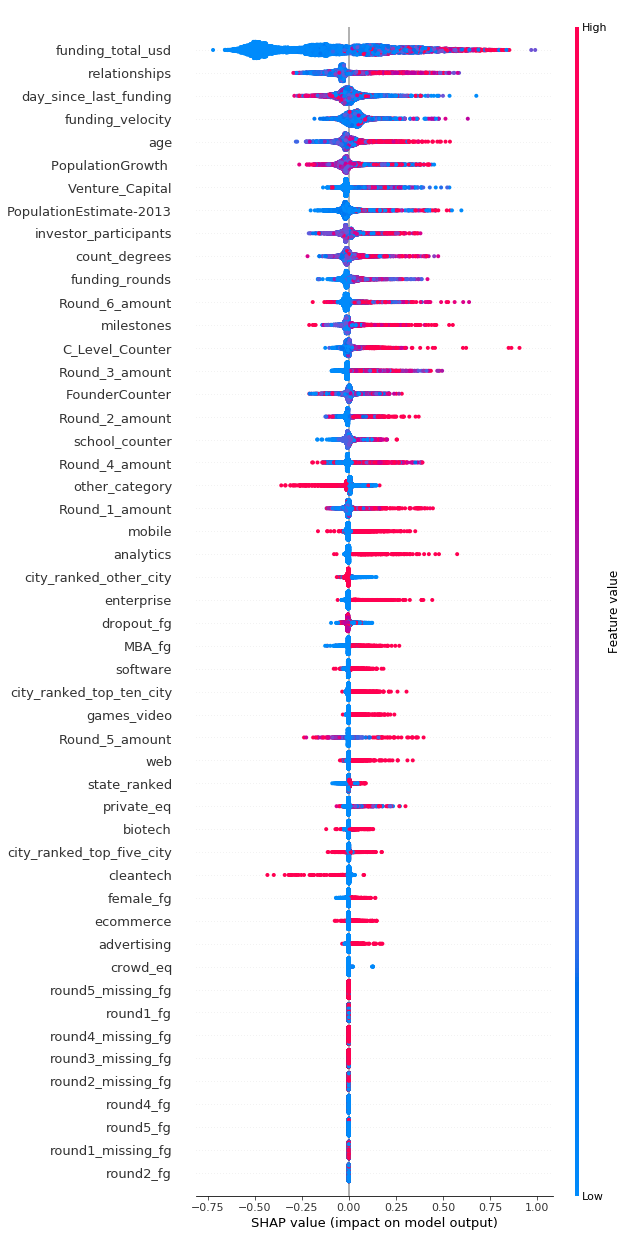

In [430]:

shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns,max_display=50)

In [431]:
#use the model to calculate the predicted probability of success 
preds = model.predict_proba(data_X)

In [433]:
#reset index to merge with the prediction columns 
data_perfect_final_test=data_perfect_final.reset_index()

In [434]:
prediction=pd.DataFrame(preds,columns=['predicted_failure','predicted_success'])

In [435]:
#merge the prediction columns with the original dataset
data_perfect_final_target=pd.concat([data_perfect_final_test,prediction],axis=1)


In [436]:
data_perfect_final_target=data_perfect_final_target.set_index('normalized_name')

In [438]:
# list of feature importance 
sorted_idx = np.argsort(model.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_train.columns[index], model.feature_importances_[index]])

['funding_total_usd', 0.21157171]
['relationships', 0.043840166]
['enterprise', 0.035413936]
['other_category', 0.031473357]
['school_counter', 0.030897839]
['Round_4_amount', 0.028709937]
['FounderCounter', 0.028487839]
['milestones', 0.027869642]
['analytics', 0.025844404]
['dropout_fg', 0.0254238]
['age', 0.024423562]
['investor_participants', 0.024101]
['funding_velocity', 0.02408473]
['Round_3_amount', 0.023865258]
['C_Level_Counter', 0.02345182]
['day_since_last_funding', 0.023296213]
['Round_1_amount', 0.02274603]
['city_ranked_other_city', 0.021319462]
['advertising', 0.02103206]
['cleantech', 0.020805612]
['PopulationGrowth ', 0.020718338]
['count_degrees', 0.019843465]
['mobile', 0.019744389]
['female_fg', 0.019617079]
['funding_rounds', 0.019240104]
['Round_5_amount', 0.018342914]
['web', 0.017781701]
['Round_6_amount', 0.017299853]
['biotech', 0.016983075]
['PopulationEstimate-2013', 0.01696976]
['private_eq', 0.016752655]
['Venture_Capital', 0.016329207]
['Round_2_amount',

In [439]:
#divide the companies to 10 deciles according to predicted success probabilities 
data_perfect_final_target['decile'] = pd.qcut(data_perfect_final_target['predicted_success'], 10, labels=False)

In [441]:
import matplotlib.pyplot as plt

# Import the scikitplot module
import scikitplot as skplt

success=np.array(data_perfect_final_target['success'])
predicted_success=np.array(data_perfect_final_target['predicted_success'])


/Users/lianxinyu/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


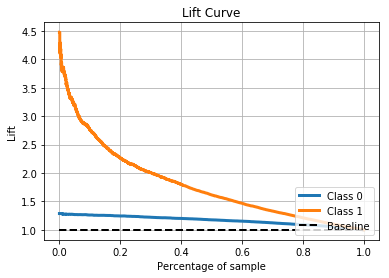

In [442]:
# Plot the lift curve
skplt.metrics.plot_lift_curve(success,preds)
plt.show()

#### KS statistic 

In [444]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [445]:
data_ks=ks(data=data_perfect_final_target,target='success', prob='predicted_success')

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.449147  0.903069     873        541     27.63%         4.93%   
2       0.355960  0.449051     560        854     17.72%         7.78%   
3       0.287440  0.355841     472        942     14.94%         8.58%   
4       0.234074  0.287430     373       1040     11.80%         9.47%   
5       0.185946  0.234042     273       1141      8.64%        10.39%   
6       0.139972  0.185946     232       1182      7.34%        10.77%   
7       0.105127  0.139960     162       1251      5.13%        11.40%   
8       0.075767  0.105092     120       1294      3.80%        11.79%   
9       0.054178  0.075760      66       1348      2.09%        12.28%   
10      0.015740  0.054177      29       1385      0.92%        12.62%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             27.63

# 2019 Data Processing

In [446]:
organizations = pd.read_csv("organizations.csv",parse_dates=[6,7,26,27,28])
organizations_1=organizations[['uuid','name','status']].copy()
del organizations
df_object = pd.read_csv("cb_objects.csv",parse_dates=[9,10,25,26,29,30,33,34,38,39])
#drop startups that was closed 
df_object = df_object.drop(df_object[df_object.status == "closed"].index)
#drop startups that went public 
df_object = df_object.drop(df_object[df_object.status == "ipo"].index)
#drop startups that was acquired  
df_object = df_object.drop(df_object[df_object.status == "acquired"].index)
df_object=df_object.drop(["status","closed_at","logo_width","logo_height","description","tag_list","region","invested_companies","parent_id","permalink","domain","homepage_url","twitter_username","logo_url","first_milestone_at","short_description","overview","last_milestone_at","created_by","created_at","updated_at"],axis=1)
#Dataset with only startups that are not yet successful in 2019 
df_object2019 = pd.merge(organizations_1,df_object,on=['name'])
del df_object
del organizations_1

/Users/lianxinyu/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,7,17,18,21,22,23,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [447]:
#remove rows not about companies 
df_object2019 = df_object2019.drop(df_object2019[df_object2019.entity_type == "Person"].index)
df_object2019 = df_object2019.drop(df_object2019[df_object2019.entity_type == "FinancialOrg"].index)
df_object2019 = df_object2019.drop(df_object2019[df_object2019.entity_type == "Product"].index)

#drop startups that was closed before the end of 2019 
df_object2019 = df_object2019.drop(df_object2019[df_object2019.status == "closed"].index)
#drop startups that went public before the end of 2019 
df_object2019 = df_object2019.drop(df_object2019[df_object2019.status == "ipo"].index)
#drop startups that was acquiredbefore the end of 2019 
df_object2019 = df_object2019.drop(df_object2019[df_object2019.status == "acquired"].index)
#drop the country with no country code or not in USA or Canada 
df_object2019=df_object2019.dropna(subset=["country_code"]) 
df_object2019=df_object2019[df_object2019['country_code'].isin(['USA','CAN'])]
df_object2019=df_object2019.drop_duplicates(['uuid','name'])
#drop startups founded before 2000 and after the end of 2013 
df_object2019=df_object2019[df_object2019['founded_at']>=pd.to_datetime('2000-01-01')]
df_object2019=df_object2019[df_object2019['founded_at']<=pd.to_datetime('2013-12-31')]
#city names changes to lower case 
df_object2019["city"]=df_object2019["city"].str.strip()
df_object2019["city"]=df_object2019["city"].str.lower()

In [448]:
df_object2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21432 entries, 1 to 152417
Data columns (total 21 columns):
uuid                   21432 non-null object
name                   21432 non-null object
status                 21432 non-null object
id                     21432 non-null object
entity_type            21432 non-null object
entity_id              21432 non-null int64
normalized_name        21432 non-null object
category_code          20935 non-null object
founded_at             21432 non-null datetime64[ns]
country_code           21432 non-null object
state_code             19517 non-null object
city                   20728 non-null object
first_investment_at    117 non-null datetime64[ns]
last_investment_at     117 non-null datetime64[ns]
investment_rounds      117 non-null float64
first_funding_at       7206 non-null datetime64[ns]
last_funding_at        7206 non-null datetime64[ns]
funding_rounds         7245 non-null float64
funding_total_usd      6645 non-null float64
mil

## 2019funding investor_participants

In [449]:
#transpose the table in cb_funding_rounds
funding_rounds=pd.read_csv("funding_rounds.csv")
#funding_rounds=cb_funding_rounds.fillna(0)
bb=pd.pivot_table(funding_rounds, values='raised_amount_usd',index=['org_uuid'], columns=['investment_type'],aggfunc=np.sum)
del funding_rounds
bb=bb.fillna(0)
bb['private_eq']=bb['private_equity']
bb['crowd_eq']=bb['equity_crowdfunding']+bb['product_crowdfunding']
bb['Round_1_amount']=bb['angel']+bb['seed']+bb['pre_seed']+bb['initial_coin_offering']
bb['Round_2_amount']=bb['series_a']
bb['Round_3_amount']=bb['series_b']
bb['Round_4_amount']=bb['series_c']
bb['Round_5_amount']=bb['series_d']+bb['series_e']+bb['series_f']+bb['series_g']+bb['series_h']+bb['series_i']+bb['series_j']
bb['Round_6_amount']=bb['debt_financing']+bb['grant']+bb['post_ipo_debt']+bb['post_ipo_equity']+bb['post_ipo_secondary']+bb['convertible_note']+bb['secondary_market'] \
+bb['corporate_round']+bb['non_equity_assistance']
#assume the startups left are funded by venture capital 
bb['Venture_Capital']=bb['undisclosed']+bb['series_unknown']
funding_rounds_1=bb[['private_eq','crowd_eq','Round_1_amount','Round_2_amount','Round_3_amount','Round_4_amount','Round_5_amount','Round_6_amount','Venture_Capital']].copy()
del bb
funding_rounds_1['uuid']=funding_rounds_1.index
funding_rounds_1.index.name=None
funding_rounds_1.columns.name=None

In [450]:
#merge with the main table 
df_object2019_1=pd.merge(df_object2019,funding_rounds_1,on=['uuid'],how='left')
del df_object2019

In [451]:
df_object2019_2 = pd.merge(df_object2019_1,cb_investments_1, how='left',on=['id'])
del df_object2019_1

In [452]:
df_object2019_3=pd.merge(df_object2019_2,popu_1,on=['city'],how='left')
del df_object2019_2

In [453]:
df_object2019_4 = pd.merge(df_object2019_3,df_count_relation_1, how='left',on=['id'])
del df_object2019_3

In [454]:
df_object2019_5 = pd.merge(df_object2019_4,people_dg_1, how='left',on=['id'])
del df_object2019_4

In [455]:
#industry flags 
df_object2019_5['software'] = np.where(df_object2019_5['category_code'] == 'software', 1, 0)
df_object2019_5['biotech'] = np.where(df_object2019_5['category_code'] == 'biotech', 1, 0)
df_object2019_5['enterprise'] = np.where(df_object2019_5['category_code'] == 'enterprise', 1, 0)
df_object2019_5['web'] = np.where(df_object2019_5['category_code'] == 'web', 1, 0)
df_object2019_5['mobile'] = np.where(df_object2019_5['category_code'] == 'mobile', 1, 0)
df_object2019_5['advertising'] = np.where(df_object2019_5['category_code'] == 'advertising', 1, 0)
df_object2019_5['ecommerce'] = np.where(df_object2019_5['category_code'] == 'ecommerce', 1, 0)
df_object2019_5['analytics'] = np.where(df_object2019_5['category_code'] == 'analytics', 1, 0)
df_object2019_5['games_video'] = np.where(df_object2019_5['category_code'] == 'games_video', 1, 0)
df_object2019_5['cleantech'] = np.where(df_object2019_5['category_code'] == 'cleantech', 1, 0)

# other industry flag 
main_category_list = ['software','biotech','enterprise','web','mobile','advertising','ecommerce','analytics','games_video','cleantech']
others = []
for item in df_object2019_5['category_code']:
    if item not in main_category_list:
        others.append(1)
    else:
        others.append(0)
df_object2019_5['other_category'] = others

In [456]:
#create round1-round6 flags based on the amount 
df_object2019_5['round1_fg'] = np.where(df_object2019_5['Round_1_amount'] > 0, 1, 0)
df_object2019_5['round2_fg'] = np.where(df_object2019_5['Round_2_amount'] > 0, 1, 0)
df_object2019_5['round3_fg'] = np.where(df_object2019_5['Round_3_amount'] > 0, 1, 0)
df_object2019_5['round4_fg'] = np.where(df_object2019_5['Round_4_amount'] > 0, 1, 0)
df_object2019_5['round5_fg'] = np.where(df_object2019_5['Round_5_amount'] > 0, 1, 0)
df_object2019_5['round6_fg'] = np.where(df_object2019_5['Round_6_amount'] > 0, 1, 0)
df_object2019_5['venture_capital_fg'] = np.where(df_object2019_5['Venture_Capital'] > 0, 1, 0)
df_object2019_5['private_eq_fg'] = np.where(df_object2019_5['private_eq'] > 0, 1, 0)
df_object2019_5['crowd_eq_fg'] = np.where(df_object2019_5['crowd_eq'] > 0, 1, 0)

In [457]:
#create flags for missing amounts 
df_object2019_5['round1_missing_fg']=np.where((df_object2019_5['Round_1_amount'] == 0)&((df_object2019_5['Round_2_amount'].notnull() == True) | (df_object2019_5['Round_3_amount'].notnull() == True) | (df_object2019_5['Round_4_amount'].notnull() == True) | (df_object2019_5['Round_5_amount'].notnull() == True) | (df_object2019_5['Round_6_amount'].notnull() == True)), 1, 0)
df_object2019_5['round2_missing_fg']=np.where((df_object2019_5['Round_2_amount'] == 0)&((df_object2019_5['Round_3_amount'].notnull() == True) | (df_object2019_5['Round_4_amount'].notnull() == True) | (df_object2019_5['Round_5_amount'].notnull() == True) | (df_object2019_5['Round_6_amount'].notnull() == True)), 1, 0)
df_object2019_5['round3_missing_fg']=np.where((df_object2019_5['Round_3_amount'] == 0)&((df_object2019_5['Round_4_amount'].notnull() == True) | (df_object2019_5['Round_5_amount'].notnull() == True) | (df_object2019_5['Round_6_amount'].notnull() == True)), 1, 0)
df_object2019_5['round4_missing_fg']=np.where((df_object2019_5['Round_4_amount'] == 0)&((df_object2019_5['Round_5_amount'].notnull() == True) | (df_object2019_5['Round_6_amount'].notnull() == True)), 1, 0)
df_object2019_5['round5_missing_fg']=np.where((df_object2019_5['Round_5_amount'] == 0)&(df_object2019_5['Round_6_amount'].notnull() == True), 1, 0)

In [458]:
df_object2019_5['city_ranked'] = np.where(df_object2019_5['city'].isin(top_five_city), 'top_five_city', 
                             (np.where(df_object2019_5['city'].isin(top_ten_city),'top_ten_city','other_city')))
df_object2019_5['state_ranked'] = np.where(df_object2019_5['state_code'].isin(top_five_state ), 'top_five_state', 'other_state')
#create flags for top 5, top 10 and other cities
df_object2019_5 = pd.get_dummies(df_object2019_5,columns=['city_ranked'])
#create a flag for top five states 
df_object2019_5['state_ranked'] = np.where(df_object2019_5['state_ranked'] == 'top_five_state', 1, 0)

In [460]:
#drop the rows with no funding_total_usd  
df_object2019_5=df_object2019_5.dropna(subset=["funding_total_usd"])
#startup age 
df_object2019_5['age'] = np.where(df_object2019_5['founded_at'].isna(),6969,(pd.to_datetime('2019-12-31')-df_object2019_5['founded_at']).apply(lambda x: x.days))/365
#funding velocity 
df_object2019_5['funding_velocity'] = df_object2019_5['funding_total_usd']/df_object2019_5['age']
#day since last funding 
df_object2019_5['day_since_last_funding'] = np.where(df_object2019_5['last_funding_at'].isna(),6969,(pd.to_datetime('2019-12-31')-df_object2019_5['last_funding_at']).apply(lambda x: x.days))

#drop the varibles that will not be used in the model 
data_final2019_5 = df_object2019_5.drop(['entity_type','entity_id','name', 'last_funding_at','first_funding_at','category_code','status','founded_at','country_code', 'state_code', 'city', 'first_investment_at','last_investment_at','investment_rounds'],axis = 1)

In [461]:
data_final2019_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6645 entries, 1 to 21431
Data columns (total 58 columns):
uuid                         6645 non-null object
id                           6645 non-null object
normalized_name              6645 non-null object
funding_rounds               6645 non-null float64
funding_total_usd            6645 non-null float64
milestones                   3929 non-null float64
relationships                5929 non-null float64
private_eq                   6220 non-null float64
crowd_eq                     6220 non-null float64
Round_1_amount               6220 non-null float64
Round_2_amount               6220 non-null float64
Round_3_amount               6220 non-null float64
Round_4_amount               6220 non-null float64
Round_5_amount               6220 non-null float64
Round_6_amount               6220 non-null float64
Venture_Capital              6220 non-null float64
investor_participants        3740 non-null float64
PopulationEstimate-2013     

In [462]:
data_final2019_5['PopulationGrowth ']=data_final2019_5['PopulationGrowth '].astype(float)

In [463]:
#impute the missing by 0
data_final2019_5['female_fg']=data_final2019_5['female_fg'].fillna(0)
data_final2019_5['milestones']=data_final2019_5['milestones'].fillna(0)
data_final2019_5['MBA_fg']=data_final2019_5['MBA_fg'].fillna(0)

In [464]:
#impute the missing of the rest of the columns by mean 
data_final2019_5=data_final2019_5.fillna(data_final_2.mean())

In [465]:
#drop duplicates
data_final2019_5=data_final2019_5.drop_duplicates(['normalized_name'])

In [483]:
data_perfect_final2019=data_final2019_5.copy()

In [484]:
data_perfect_final2019.to_csv('data_perfect_final2019_1.csv')

## Apply XGBoost Model Trained with 2013 Dataset

In [485]:
data_perfect_final2019 = pd.read_csv("data_perfect_final2019_1.csv")

In [487]:
#drop the columns that will not be used in the model

data_perfect_final2019 = data_perfect_final2019.drop(['Unnamed: 0','id','uuid'],axis = 1)

In [488]:
#standard scaling the variables with large values 
df1=StandardScaler.fit_transform(data_perfect_final2019[['Round_1_amount','Round_2_amount','Round_3_amount','Round_4_amount','Round_5_amount','Round_6_amount',\
                              'funding_total_usd','PopulationEstimate-2013','day_since_last_funding','age','private_eq','Venture_Capital','crowd_eq']])

In [489]:
df2=pd.DataFrame(df1,columns=['Round_1_amount','Round_2_amount','Round_3_amount','Round_4_amount','Round_5_amount','Round_6_amount',\
                              'funding_total_usd','PopulationEstimate-2013','day_since_last_funding','age','private_eq','Venture_Capital','crowd_eq'])
df1=data_perfect_final2019.drop(['Round_1_amount','Round_2_amount','Round_3_amount','Round_4_amount','Round_5_amount','Round_6_amount',\
                              'funding_total_usd','PopulationEstimate-2013','day_since_last_funding','age','private_eq','Venture_Capital','crowd_eq'],axis=1)
data_perfect_final2019=pd.concat([df1,df2],axis=1)

In [490]:
data_perfect_final2019=data_perfect_final2019[['normalized_name','funding_rounds','count_degrees','day_since_last_funding','funding_total_usd', 'milestones','dropout_fg','relationships', 'PopulationEstimate-2013', 'PopulationGrowth ', 'private_eq', 'crowd_eq', 'Round_1_amount', 'Round_2_amount', 'Round_3_amount', 'Round_4_amount', 'Round_5_amount', 'Round_6_amount', 'Venture_Capital', 'investor_participants', 'FounderCounter', 'C_Level_Counter', 'school_counter', 'female_fg', 'MBA_fg', 'state_ranked', 'city_ranked_other_city', 'city_ranked_top_five_city', 'city_ranked_top_ten_city', 'round1_fg', 'round2_fg', 'round3_fg', 'round4_fg', 'round5_fg', 'round6_fg', 'venture_capital_fg', 'private_eq_fg', 'crowd_eq_fg', 'round1_missing_fg', 'round2_missing_fg', 'round3_missing_fg', 'round4_missing_fg', 'round5_missing_fg', 'software', 'biotech', 'enterprise', 'web', 'mobile', 'advertising', 'ecommerce', 'analytics', 'games_video', 'cleantech', 'other_category', 'age', 'funding_velocity']]

In [491]:
data_perfect_final2019=data_perfect_final2019.set_index('normalized_name')

In [492]:
#Discrepancy occured due to large Funding velocity values. To tackle those the next few steps were done
data_perfect_final2019=data_perfect_final2019.replace([np.inf,-np.inf],np.nan)

In [493]:
data_perfect_final2019=data_perfect_final2019.dropna()

In [494]:
data_perfect_final2019.shape

(6331, 55)

In [495]:
preds2019 = model.predict_proba(data_perfect_final2019)

In [497]:
#reset the index to add the prediction columns 
data_perfect_final2019_test=data_perfect_final2019.reset_index()

In [498]:
prediction=pd.DataFrame(preds2019,columns=['predicted_failure','predicted_success'])

In [499]:
#merge the prediction columns with the original data file 
data_perfect_final2019_target=pd.concat([data_perfect_final2019_test,prediction],axis=1)

In [500]:
#set the index as normalized name 
data_perfect_final2019_target=data_perfect_final2019_target.set_index('normalized_name')

In [502]:
#divide the companies in deciles according to predicted success
data_perfect_final2019_target['decile'] = pd.qcut(data_perfect_final2019_target['predicted_success'], 10, labels=False)

In [504]:
#copy the prediction columns 
data_perfect_final2019_target1=data_perfect_final2019_target[['predicted_failure','predicted_success','decile']].copy()

In [506]:
#original 2019 dataset 
data_final2019_5=data_final2019_5.set_index('normalized_name')

In [507]:
#merge the prediction columns with 2019 dataset 
data_perfect_final2019_target=pd.concat([data_final2019_5,data_perfect_final2019_target1],axis=1)

In [508]:
#drop the ids 
data_perfect_final2019_target = data_perfect_final2019_target.drop(['id','uuid'],axis = 1)

In [509]:
#final dataset with predictions 
data_perfect_final2019_target.head()

,funding_rounds,funding_total_usd,milestones,relationships,...,day_since_last_funding,predicted_failure,predicted_success,decile
normalized_name,,,,,,,,,
scribd,5.0,25762000.0,4.0,21.0,...,3269.0,0.493414,0.506586,9
meetmoi,3.0,5575000.0,0.0,5.0,...,3773.0,0.771089,0.228911,4
openx,5.0,75511200.0,7.0,55.0,...,2539.0,0.339923,0.660077,9
mahalo,2.0,21000000.0,0.0,13.0,...,4747.0,0.682958,0.317042,7
funny or die,4.0,18000000.0,2.0,16.0,...,4025.0,0.591437,0.408563,8


In [510]:
data_perfect_final2019_target.to_csv('data_perfect_final2019_Decile.csv')